<a href="https://colab.research.google.com/github/Mostafa3zazi/CISC-856-Reinforcement-Learning/blob/main/RL_project_Mountain_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mountain Car
The Mountain car is an environment where a car must climb a mountain. Because gravity is stronger than the car's engine, it cannot merely accelerate up the steep slope even with full throttle. The vehicle is situated in a valley and must learn to utilize potential energy by driving up the opposite hill before the car can make it to the goal at the top of the rightmost hill.

> The mountain car environment provides the following discrete actions:

> * 0 - Apply left force
* 1 - Apply no force
* 2 - Apply right force

> The mountain car environment is made up of the following continuous values:

> * state[0] - Position 
* state[1] - Velocity


# Deep Q-Network (DQN) stable baselines3
> ### DQN algorithm

> Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

> Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

> The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

> \begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

> However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.








In [ ]:
# !pip install stable-baselines[mpi]==2.10.2


In [ ]:
%%capture
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt install swig cmake libopenmpi-dev zlib1g-dev
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]


In [ ]:
import time
import os
import gym
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

## initialize model and Env

In [ ]:
# create environment for training
log_dir = '/content/train_log'
env = gym.make('MountainCar-v0')

In [ ]:
'''
 these hyperparams values are chosen according to rl-baselines3-zoo
 they used Optuna for optimizing the hyperparameters.
 training should give great results but we may try to tune the hyperparams more
 (we may give it a try)
'''

kwargs = {
    'env': env,
    'policy': 'MlpPolicy',
    'learning_rate': 4e-3,
    'batch_size': 128,
    'buffer_size': 10000,
    'learning_starts': 1000,
    'gamma': 0.98,
    'target_update_interval': 600,
    'train_freq': 16,
    'gradient_steps': 8,
    'exploration_fraction': 0.2,
    'exploration_final_eps': 0.07,
    'policy_kwargs': dict(net_arch=[256, 256]),
    'verbose': 1
  }
n_timesteps = 1.2e5

In [ ]:
#create the model
dqn_model = DQN(**kwargs)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## Create Callback to monitor traing/testing and save best model

In [ ]:
class DoneCallback(BaseCallback):
    """
    Callback for monitoring the trainig process (rewards, episodes and timesteps)
    Evaluate the model every 10 trining episodes and monitor the testing rewards and time step
    Saving the best model according to the evalution rewards.

    """
    def __init__(self, reward_list,
                 time_steps_list, 
                 eval_env,
                 eval_reward_list,
                 eval_time_steps_list,
                 max_number_of_episodes,
                 save_path = '',
                 verbose = 0
                 ):
      
        super(DoneCallback, self).__init__(verbose)        
        self.reward_list = reward_list
        self.time_steps_list = time_steps_list
        self.eval_env = eval_env
        self.eval_reward_list = eval_reward_list
        self.eval_time_steps_list = eval_time_steps_list
        self.max_number_of_episodes = max_number_of_episodes
        self.save_path = None
        if save_path:
          self.save_path = os.path.join(save_path, 'best_model')

        self.best_evalution_reward = np.NINF
        self.number_of_episodes = 0

    def _on_step(self) -> bool:

      if np.all(self.locals['dones']):
        
        #Evaluation
        if (self.number_of_episodes % 10 == 0) and (self.number_of_episodes != 0):
          rewards, steps = evaluate_policy(self.model, self.eval_env, n_eval_episodes=5, deterministic = True ,return_episode_rewards = True)
          self.eval_reward_list.append(np.mean(rewards))
          self.eval_time_steps_list.append(np.mean(steps))

          # saving the new best model
          if np.mean(rewards) > self.best_evalution_reward:
              self.best_evalution_reward = np.mean(rewards)
              if self.save_path:
                self.model.save(self.save_path)
                if self.verbose > 0:
                  print(f"Saving new best model to {self.save_path} with mean reward of {self.best_evalution_reward}")
              


        #Monitor training
        self.number_of_episodes += 1
        self.reward_list.append(self.locals['infos'][0]['episode']['r'])
        self.time_steps_list.append(self.locals['infos'][0]['episode']['l'])
        if self.number_of_episodes > self.max_number_of_episodes:
          return False
      
      return True

In [ ]:

# Use a separate environement for evaluation
eval_env = gym.make('MountainCar-v0')

In [ ]:
#create the callback and required lists to monitor training and testing
reward_list = []
time_steps_list = []
eval_reward_list = []
eval_time_steps_list = []

callback = DoneCallback(reward_list = reward_list,
                 time_steps_list = time_steps_list, 
                 eval_env = eval_env,
                 eval_reward_list = eval_reward_list,
                 eval_time_steps_list = eval_time_steps_list,
                 max_number_of_episodes = 800,
                 save_path = '/content/',
                 verbose = 1)

## Train model

In [ ]:
# Train the agent for n_timesteps
dqn_model.learn(total_timesteps = n_timesteps, log_interval=100, callback=callback)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Saving new best model to /content/best_model with mean reward of -200.0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.225    |
| time/               |          |
|    episodes         | 100      |
|    fps              | 343      |
|    time_elapsed     | 58       |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 3.52e-05 |
|    n_updates        | 9496     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 195      |
|    ep_rew_mean      | -195     |
|    exploration_rate | 0.07     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 318      |
|    time_elapsed     | 124      |
|    total_timesteps  | 39478    |
| train/              |          |
|    learning_rate

## Prepare video recording

In [ ]:
!rm -r videos

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [ ]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # eval_env._max_episode_steps = 1000
  # eval_env._timestep_limit = 1000
  # eval_env.env_method('timestep_limit',1000)

  # print(eval_env.get_attr('_max_episode_steps'))

  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger= lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs, deterministic = True)
    obs, _, done, _ = eval_env.step(action)
    if done: 
      break

  # Close the video recorder
  eval_env.close()

## Visualize trained agent



In [ ]:
best_dqn_model = DQN.load("/content/best_model.zip", env=eval_env)
record_video('MountainCar-v0', best_dqn_model, video_length=500, prefix='dqn-MountainCar')

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
show_videos('videos', prefix='dqn')

## Check Performance of the model
time steps is the same value as reward but in a negative sign because the agent is penalised with a reward of -1 for each timestep.

but anyway we will provide both plots

In [ ]:
def plot_cumulative_reward_per_episode(reward_list):
  plt.figure(figsize = (10,6))
  plt.plot(reward_list)
  plt.axhline(y = max(reward_list), color='r', linestyle='--')
  plt.title('Cumulative reward per episode')
  plt.xlabel('episodes')
  plt.ylabel('Cumulative reward')


In [ ]:
def plot_timestep_per_episode(time_steps_list):
  plt.figure(figsize = (10,6))
  plt.plot(time_steps_list)
  plt.axhline(y = min(time_steps_list), color='r', linestyle='--')
  plt.title('time steps per episode')
  plt.xlabel('episodes')
  plt.ylabel('time steps')

### Training

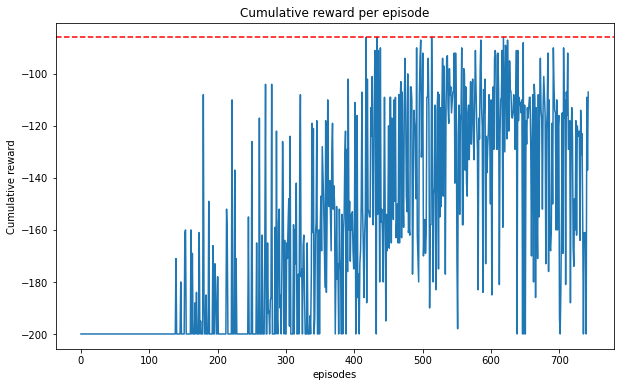

In [ ]:
plot_cumulative_reward_per_episode(reward_list)

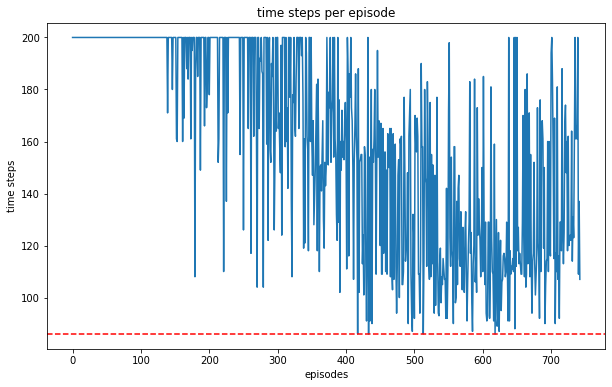

In [ ]:
plot_timestep_per_episode(time_steps_list)

### Testing

Text(0, 0.5, 'Mean cumulative reward')

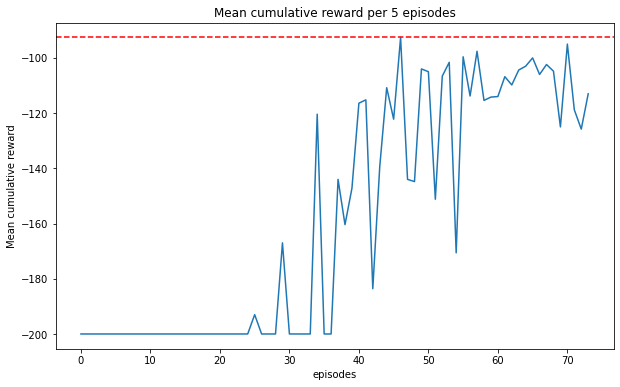

In [ ]:
#mean cumulative reward per 5 episodes
plot_cumulative_reward_per_episode(eval_reward_list)
plt.title('Mean cumulative reward per 5 episodes')
plt.xlabel('episodes')
plt.ylabel('Mean cumulative reward')

Text(0, 0.5, 'Mean timesteps')

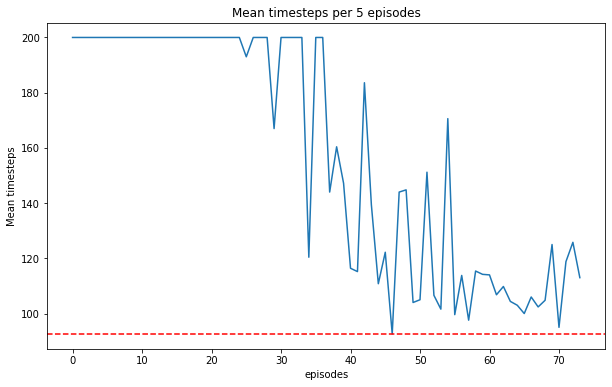

In [ ]:
#mean timesteps reward per 5 episodes
plot_timestep_per_episode(eval_time_steps_list)
plt.title('Mean timesteps per 5 episodes')
plt.xlabel('episodes')
plt.ylabel('Mean timesteps')

## Hyper parameters tunning

In [ ]:
np.argmax(reward_list)

417

In [ ]:
np.sum(time_steps_list[:417])

77601

the previous trial tool 417 to reach the optimal solution with 77601 time step so we will train for 500 episodes only fro the upcomming trials.

Trying different values of gamma and epsilon

In [ ]:
kwargs = {
    'env': env,
    'policy': 'MlpPolicy',
    'learning_rate': 4e-3,
    'batch_size': 128,
    'buffer_size': 10000,
    'learning_starts': 1000,
    'target_update_interval': 600,
    'train_freq': 16,
    'gradient_steps': 8,
    'exploration_final_eps': 0.07,
    'policy_kwargs': dict(net_arch=[256, 256]),
    'verbose': 0
  }
gamma  = [0.99 , 0.97]
exploration_fraction =  [0.3,0.1]

results_df = pd.DataFrame()

for g in gamma:
  for e in exploration_fraction:
    print(f'trining gamma {g} and exploration_rate {e}')
    dqn_model = DQN(**kwargs, gamma = g, exploration_fraction = e)
    temp_reward_list = []
    temp_time_steps_list = []
    temp_eval_reward_list = []
    temp_eval_time_steps_list = []
    callback = DoneCallback(reward_list = temp_reward_list,
                    time_steps_list = temp_time_steps_list, 
                    eval_env = eval_env,
                    eval_reward_list = temp_eval_reward_list,
                    eval_time_steps_list = temp_eval_time_steps_list,
                    max_number_of_episodes = 800,
                    save_path = None,
                    verbose = 0)
    
    dqn_model.learn(total_timesteps = n_timesteps, log_interval=100000000, callback=callback)

    temp_df = pd.DataFrame()
    temp_df['reward_list'] = temp_reward_list
    temp_df['gamma'] = g
    temp_df['exploration_rate'] = e
    results_df = pd.concat([results_df,temp_df])
    

trining gamma 0.99 and exploration_rate 0.3


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


trining gamma 0.99 and exploration_rate 0.1
trining gamma 0.97 and exploration_rate 0.3
trining gamma 0.97 and exploration_rate 0.1


the upcomming 3 cells from : https://towardsdatascience.com/hands-on-reinforcement-learning-course-part-2-1b0828a1046b

In [ ]:
results_df = results_df.reset_index().rename(columns = {'index':'episode'})

In [ ]:
results_df['hyperparam'] = [f'gamma = {g}, exploration_rate = {e}' for (g,e) in zip(results_df['gamma'],results_df['exploration_rate'])]

In [ ]:
results_df

,episode,reward_list,gamma,exploration_rate,hyperparam
0,0,-200.0,0.99,0.3,"gamma = 0.99, exploration_rate = 0.3"
1,1,-200.0,0.99,0.3,"gamma = 0.99, exploration_rate = 0.3"
2,2,-200.0,0.99,0.3,"gamma = 0.99, exploration_rate = 0.3"
3,3,-200.0,0.99,0.3,"gamma = 0.99, exploration_rate = 0.3"
4,4,-200.0,0.99,0.3,"gamma = 0.99, exploration_rate = 0.3"
...,...,...,...,...,...
2822,716,-168.0,0.97,0.1,"gamma = 0.97, exploration_rate = 0.1"
2823,717,-151.0,0.97,0.1,"gamma = 0.97, exploration_rate = 0.1"
2824,718,-172.0,0.97,0.1,"gamma = 0.97, exploration_rate = 0.1"
2825,719,-92.0,0.97,0.1,"gamma = 0.97, exploration_rate = 0.1"


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


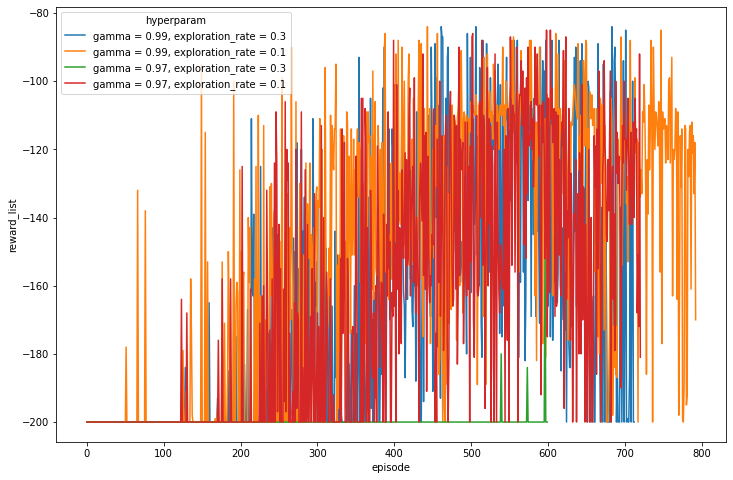

In [ ]:
import seaborn as sns
fig = plt.gcf()
fig.set_size_inches(12,8)
sns.lineplot('episode','reward_list',hue = 'hyperparam', data = results_df)

make the plot easier to read

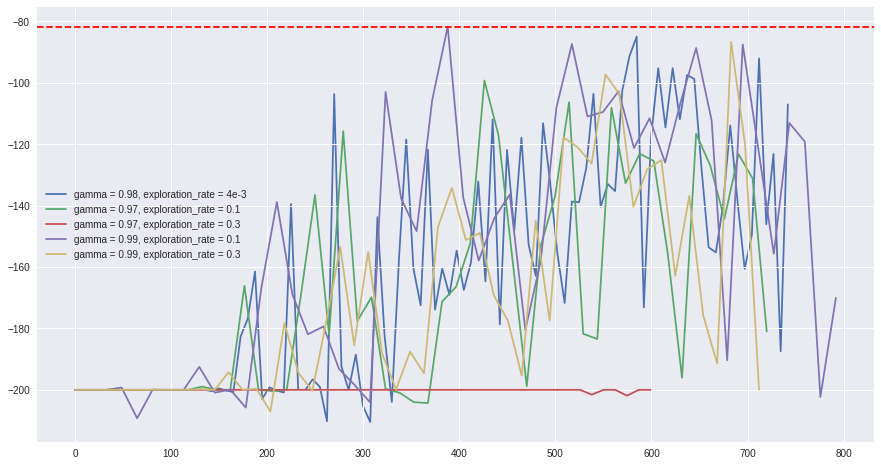

In [ ]:
from scipy.interpolate import make_interp_spline
plt.figure(figsize = (15,8))
plt.style.use('seaborn')
max_value = max(reward_list)
best_params = 'gamma = 0.98, exploration_rate = 4e-3'


B_spline_coeff = make_interp_spline(np.arange(len(reward_list)), reward_list)
X_Final = np.linspace(0 , len(reward_list) - 1, 100)
Y_Final = B_spline_coeff(X_Final)
plt.plot(X_Final,Y_Final,label = 'gamma = 0.98, exploration_rate = 4e-3',zorder = 0)
max_value = max(Y_Final)

for hyperparam, df in results_df.groupby('hyperparam'):
    B_spline_coeff = make_interp_spline(df['episode'], df['reward_list'])
    X_Final = np.linspace(df['episode'].min(), df['episode'].max(), 50)
    Y_Final = B_spline_coeff(X_Final)
    plt.plot(X_Final,Y_Final,label = hyperparam)
    if max(Y_Final) > max_value:
      max_value = max(Y_Final)
      best_params = hyperparam


plt.legend()

plt.axhline(y = max_value, color='r', linestyle='--')





In [ ]:
best_params

'gamma = 0.99, exploration_rate = 0.1'

it looks like gamma = 0.99, exploration_rate = 0.1 may achieve better performance but the current performance is sufficient